# Prophet

In [7]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import numpy as np
import pickle

## Load data

In [8]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1571,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False
1572,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False
1573,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False
1574,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False


## Prophet

In [9]:
df = df[['Date', 'Revenue Losses', 'Train', 'Outlier']].rename(columns={'Revenue Losses': 'y', 'Date': 'ds'})
df

,ds,y,Train,Outlier
0,2020-10-25,221250.0,True,False
1,2020-10-26,233125.0,True,False
2,2020-10-27,266875.0,True,False
3,2020-10-28,244375.0,True,False
4,2020-10-29,233750.0,True,False
...,...,...,...,...
1571,2025-02-12,798125.0,False,False
1572,2025-02-13,743125.0,False,False
1573,2025-02-14,667500.0,False,False
1574,2025-02-15,691875.0,False,False


In [10]:
# Add a column of indicators for each row to indicate whether the row is an outlier
# This might not be super necessary since prophet is generally robust, but some of these are rather extreme
outlier_cols = []
for i in range(len(df)):
    if df.loc[i, 'Outlier'] == 1:
        df['Outlier_' + str(df['ds'][i])] = [1 if j == i else 0 for j in range(len(df))]
        outlier_cols.append('Outlier_' + str(df['ds'][i]))
df

C:\Users\ijyli\AppData\Local\Temp\ipykernel_18356\4004347482.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Outlier_' + str(df['ds'][i])] = [1 if j == i else 0 for j in range(len(df))]
C:\Users\ijyli\AppData\Local\Temp\ipykernel_18356\4004347482.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Outlier_' + str(df['ds'][i])] = [1 if j == i else 0 for j in range(len(df))]
C:\Users\ijyli\AppData\Local\Temp\ipykernel_18356\4004347482.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

,ds,y,Train,Outlier,Outlier_2020-12-14 00:00:00,Outlier_2021-07-07 00:00:00,Outlier_2021-07-08 00:00:00,Outlier_2021-07-09 00:00:00,Outlier_2021-07-10 00:00:00,Outlier_2021-07-11 00:00:00,...,Outlier_2024-09-01 00:00:00,Outlier_2024-09-02 00:00:00,Outlier_2024-09-03 00:00:00,Outlier_2024-09-04 00:00:00,Outlier_2024-09-05 00:00:00,Outlier_2024-09-06 00:00:00,Outlier_2024-09-07 00:00:00,Outlier_2024-09-08 00:00:00,Outlier_2024-09-09 00:00:00,Outlier_2024-11-15 00:00:00
0,2020-10-25,221250.0,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-10-26,233125.0,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-10-27,266875.0,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-10-28,244375.0,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-10-29,233750.0,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,2025-02-12,798125.0,False,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1572,2025-02-13,743125.0,False,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1573,2025-02-14,667500.0,False,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1574,2025-02-15,691875.0,False,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Train/test split
train_df = df.query('Train == 1').drop(columns = ['Train', 'Outlier'])
test_df = df.query('Train == 0').drop(columns = ['Train', 'Outlier'])
print(len(train_df), len(test_df))
train_df

1546 30


,ds,y,Outlier_2020-12-14 00:00:00,Outlier_2021-07-07 00:00:00,Outlier_2021-07-08 00:00:00,Outlier_2021-07-09 00:00:00,Outlier_2021-07-10 00:00:00,Outlier_2021-07-11 00:00:00,Outlier_2021-07-12 00:00:00,Outlier_2021-07-13 00:00:00,...,Outlier_2024-09-01 00:00:00,Outlier_2024-09-02 00:00:00,Outlier_2024-09-03 00:00:00,Outlier_2024-09-04 00:00:00,Outlier_2024-09-05 00:00:00,Outlier_2024-09-06 00:00:00,Outlier_2024-09-07 00:00:00,Outlier_2024-09-08 00:00:00,Outlier_2024-09-09 00:00:00,Outlier_2024-11-15 00:00:00
0,2020-10-25,221250.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-10-26,233125.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-10-27,266875.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-10-28,244375.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-10-29,233750.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,2025-01-13,1049375.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1542,2025-01-14,997500.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1543,2025-01-15,1057500.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1544,2025-01-16,864375.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Hyperparameter tuning
# Going with the most commonly tuned items for seasonality and changepoint priors

param_grid = {
    'changepoint_prior_scale': [0.05, 0.35, 0.4, 0.45],
    'seasonality_prior_scale': [0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    # Add outlier columns
    for col in outlier_cols:
        m.add_regressor(col)
    m = m.fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0]) # will optimize on rmse for now, should be very mindful of outliers

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

23:10:13 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing
23:10:39 - cmdstanpy - INFO - Chain [1] start processing
23:10:39 - cmdstanpy - INFO - Chain [1] done processing
23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing
23:11:32 - cmdstanpy - INFO - Chain [1] start processing
23:11:33 - cmdstanpy - INFO - Chain [1] done processing
23:12:17 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing
23:13:09 - cmdstanpy - INFO - Chain [1] start processing
23:13:10 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:13 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:24 - cmdstanpy - INFO - Chain [1] done processing
23:16:27 - cmdstanpy - INFO - Chain [1] start processing
23:16:29 - cmdstanpy - INFO - Chain [1]

In [13]:
print(tuning_results.sort_values('rmse', ascending = True))

    changepoint_prior_scale  seasonality_prior_scale           rmse
9                      0.45                      0.1  258971.444534
3                      0.35                      0.1  259167.972977
4                      0.35                      1.0  259275.396729
8                      0.40                     10.0  259477.379600
6                      0.40                      0.1  259537.564466
11                     0.45                     10.0  259618.229388
5                      0.35                     10.0  259693.087872
7                      0.40                      1.0  259807.550391
10                     0.45                      1.0  260251.198620
0                      0.05                      0.1  272016.893030
2                      0.05                     10.0  272210.964640
1                      0.05                      1.0  272234.126148


23:20:17 - cmdstanpy - INFO - Chain [1] start processing
23:20:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ijyli\AppData\Local\Temp\ipykernel_18356\2124412388.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[col] = [0] * len(future)
C:\Users\ijyli\AppData\Local\Temp\ipykernel_18356\2124412388.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[col] = [0] * len(future)
C:\Users\ijyli\AppData\Local\Temp\ipykernel_18356\2124412388.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is 

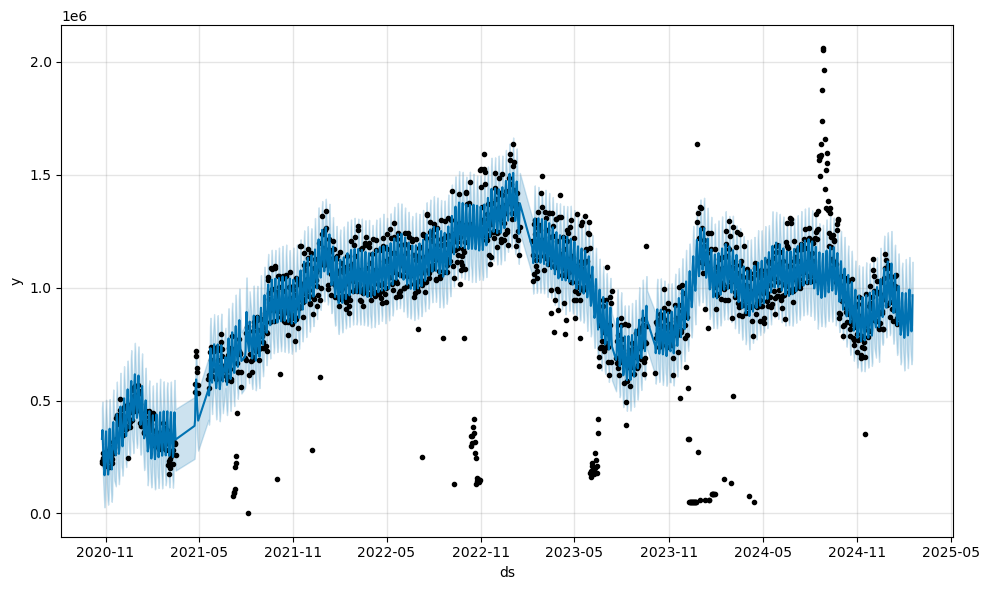

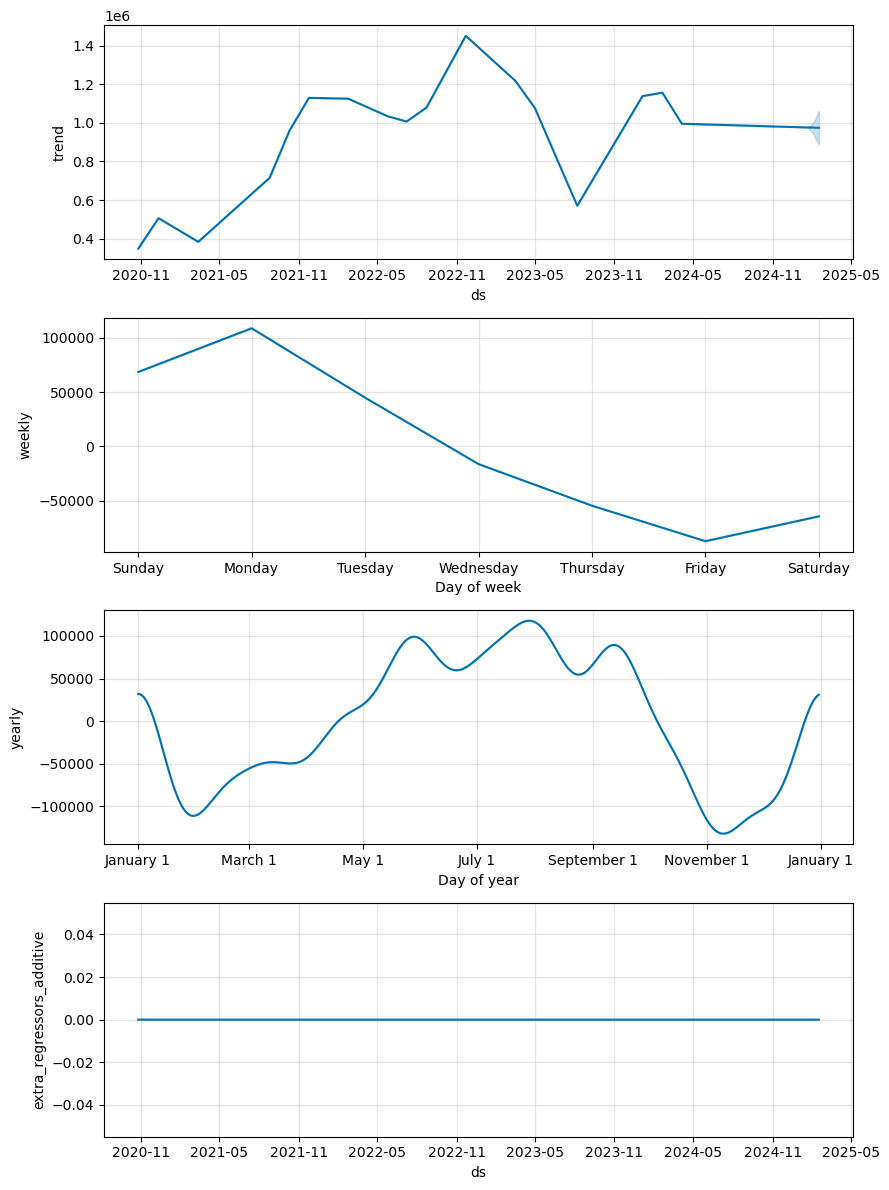

In [14]:
# Fit model
m = Prophet(
    interval_width=0.95, # standard intervals
    seasonality_prior_scale=tuning_results.sort_values('rmse', ascending = True).iloc[0]['seasonality_prior_scale'], # from tuning
    changepoint_prior_scale=tuning_results.sort_values('rmse', ascending = True).iloc[0]['changepoint_prior_scale'] # from tuning
)

# Add outlier columns
for col in outlier_cols:
    m.add_regressor(col)

m.fit(train_df)

future = m.make_future_dataframe(periods=30)

for col in outlier_cols:
    future[col] = [0] * len(future)

forecast = m.predict(future)

fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)

In [15]:
# Save model to disk
with open('Models/Prophet.pkl', 'wb') as pkl:
    pickle.dump(m, pkl)

In [16]:
# Check residuals
def plot_prophet_residuals(m, df, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for Prophet.

    Args:
        m: The fitted Prophet model object.
        df: The original DataFrame used to fit the model.
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    forecast = m.predict(df)
    df['residuals'] = df['y'] - forecast['yhat']
    residuals = df['residuals']
    fitted_values = forecast['yhat']  # Use predicted values

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(df['ds'], residuals) # Plot against 'ds' (date)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1], title='Autocorrelation Function (ACF)') # Set title here
    #axes[1, 1].set_title('Autocorrelation Function (ACF)')  # No need to set title separately

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    fig.delaxes(axes[2, 1])  # Remove the empty subplot

    plt.tight_layout()
    plt.show()


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\prophet\forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)
C:\Users\ijyli\AppData\Local\Temp\ipykernel_18356\202755531.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['residuals'] = df['y'] - forecast['yhat']


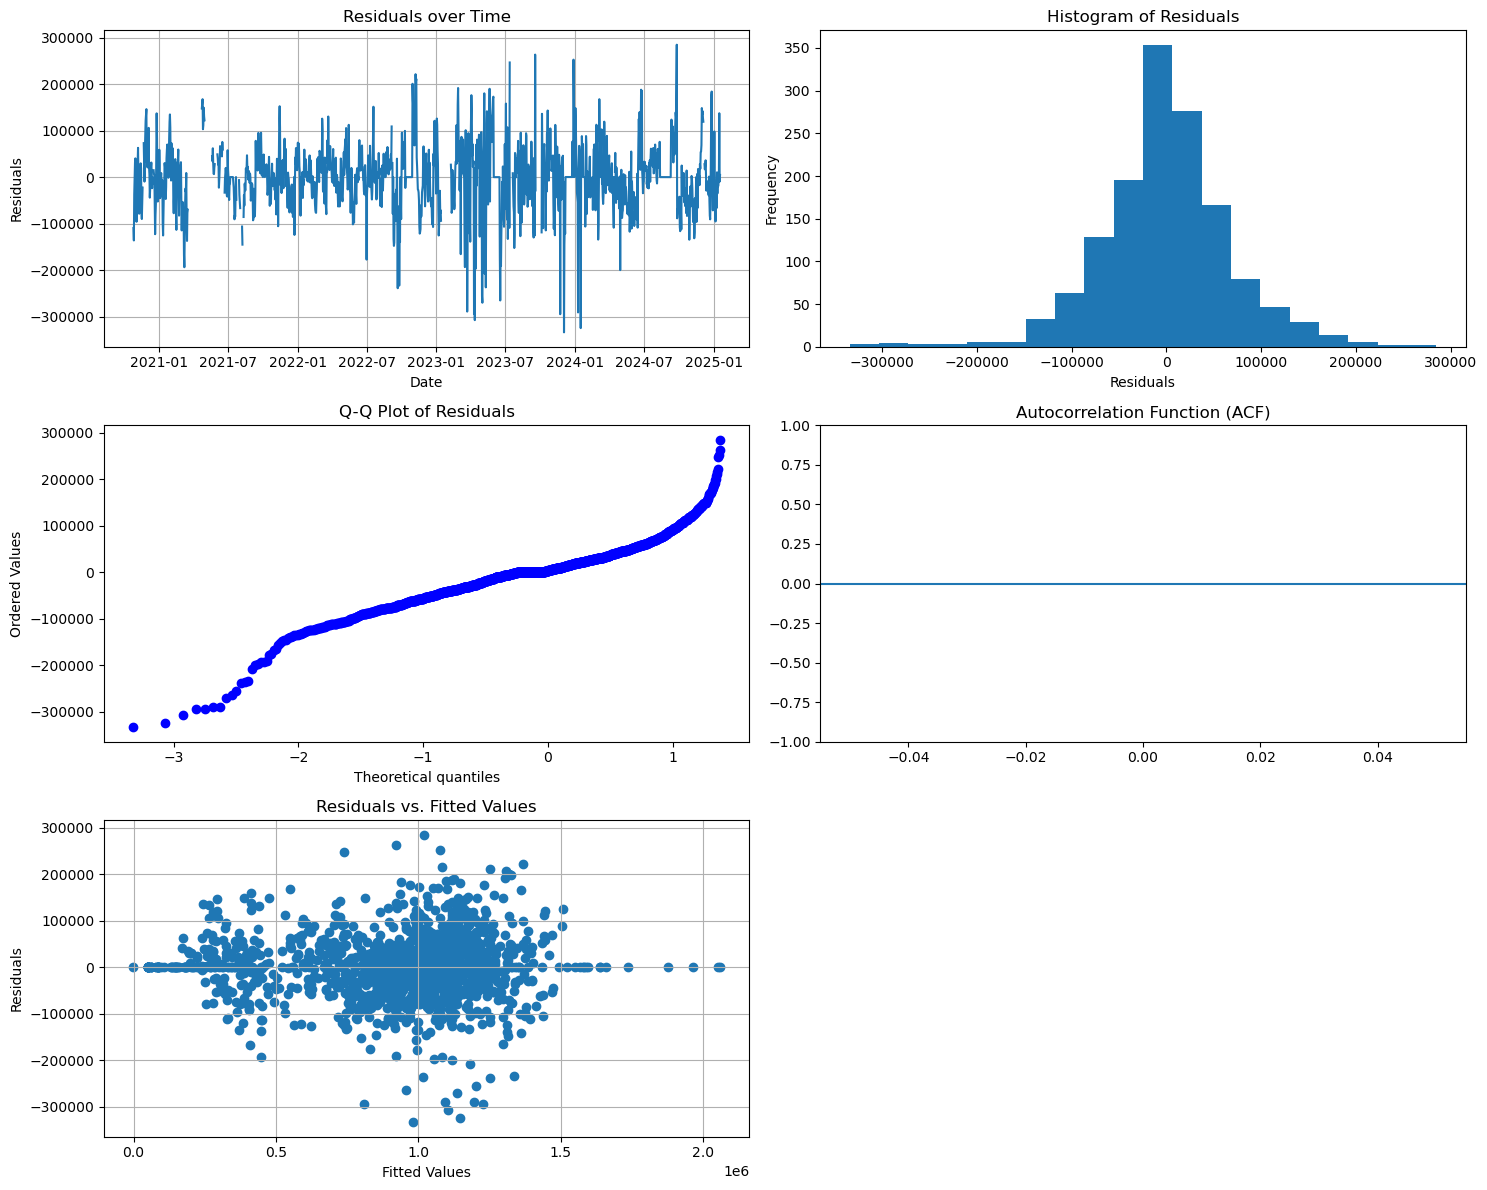

In [17]:
plot_prophet_residuals(m, train_df)

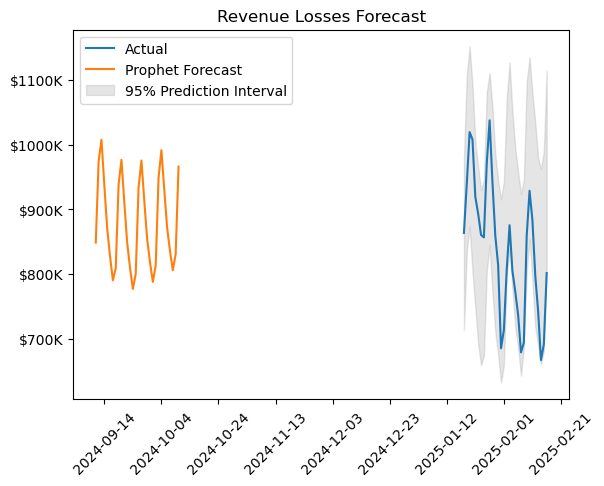

MAE: 73796.6464374988
RMSE: nan
MAPE: nan


In [18]:
plt.plot(test_df['y'], label="Actual")
plt.plot(forecast['yhat'][-len(test_df):], label="Prophet Forecast")
# Add prophet prediction intervals
plt.fill_between(test_df.index, forecast['yhat_lower'][-len(test_df):], forecast['yhat_upper'][-len(test_df):], color='gray', alpha=0.2, label='95% Prediction Interval')
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['ds'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['y'], forecast['yhat'][-len(test_df):])
rmse = np.sqrt(np.mean((test_df['y'] - forecast['yhat'][-len(test_df):])**2))
print('MAE:', mae)
print('RMSE:', rmse)
# Also compute MAPE for reporting
mape = np.mean(np.abs((test_df['y'] - forecast['yhat'][-len(test_df):]) / test_df['y'])) * 100
print('MAPE:', mape)

In [19]:
# 7-day seasonal naive forecast for comparison
last_7 = list(train_df['y'][-7:])
seasonal_naive_forecast = [last_7[i % 7] for i in range(len(test_df))]
# Set index of dates to be that of test_df
seasonal_naive_forecast_df = pd.DataFrame(seasonal_naive_forecast, index=test_df.index, columns=['y'])

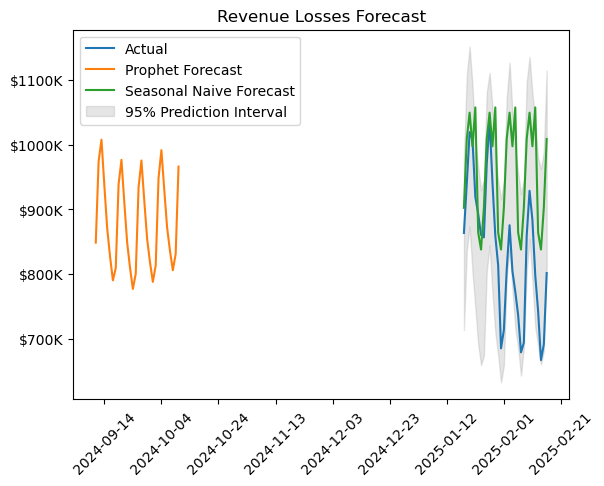

Seasonal Naive MAE: 125937.5
Seasonal Naive RMSE: 147947.10660964838
Seasonal Naive MAPE: 16.031803306760448


In [20]:
# PLot with seasonal naive forecast
plt.plot(test_df['y'], label="Actual")
plt.plot(forecast['yhat'][-len(test_df):], label="Prophet Forecast")
# Seasonal naive forecast
plt.plot(seasonal_naive_forecast_df['y'], label="Seasonal Naive Forecast")
# Add prophet prediction intervals
plt.fill_between(test_df.index, forecast['yhat_lower'][-len(test_df):], forecast['yhat_upper'][-len(test_df):], color='gray', alpha=0.2, label='95% Prediction Interval')
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['ds'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# MAE, RMSE, MAPE for seasonal naive forecast
mae = mean_absolute_error(test_df['y'], seasonal_naive_forecast)
rmse = np.sqrt(np.mean((test_df['y'] - seasonal_naive_forecast)**2))
print('Seasonal Naive MAE:', mae)
print('Seasonal Naive RMSE:', rmse)
mape = np.mean(np.abs((test_df['y'] - seasonal_naive_forecast) / test_df['y'])) * 100
print('Seasonal Naive MAPE:', mape)

Forecasts seem to be very good.